In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from umap import UMAP
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder

current_dir = os.getcwd()

### Politicians Labelling Functions

In [4]:
def label_frontal_faces(labeled_df, politic):
    politic1 = labeled_df[labeled_df['cluster_label'] == politic]
    politic1 = politic1[politic1['poses'].apply(lambda x: len(x) == 1)]
    politic1 = politic1[politic1['fer'].apply(lambda x: len(x) == 1)]
    #print("frames with 1 pose and 1 face:")
    #print(len(politic1))    
    
    # Calculate x_line length for the politic 1 faces
    x_lines = []
    indices = politic1.index.tolist()
    
    for i, frame in enumerate(politic1['poses']):
        for pose in frame:
            face = [point[:3] for point in pose[:11]]
            x_values = [point[0] for point in face]
            x_left_eye = x_values[6]
            x_right_eye = x_values[3]
            x_line = abs(max(x_left_eye, x_right_eye) - min(x_left_eye, x_right_eye))
            x_lines.append((indices[i], x_line))
    
    # Add x_line lengths as a new column
    x_lines_dict = dict(x_lines)
    politic1['x_line'] = politic1.index.map(x_lines_dict)
    
    # Sort the DataFrame by x_line length
    politic1_sorted = politic1.sort_values(by='x_line', ascending=False)
    
    #for the first 50 frames, add a column "frontal_view" to True
    politic1_sorted['frontal_view'] = False
    for i in range(100):
        politic1_sorted.loc[politic1_sorted.index[i], 'frontal_view'] = True
        
    labeled_df.loc[labeled_df['cluster_label'] == politic, 'frontal_view'] = politic1_sorted['frontal_view']
    
    #visualize_labeled_df(labeled_df[labeled_df['frontal_view'] == True], images_per_cluster=100, images_per_row=10)
    
    return labeled_df

def filter_videos(video_titles, party):
    party_videos = [video for video in video_titles if video.startswith(party) or video.endswith(party)]
    return party_videos

def load_data(video, parent_dir):
    return pd.read_pickle(os.path.join(parent_dir, 'labeled', video + '_labeled_frontal.pkl'))

def extract_embeddings(data):
    # Filter for frontal views only once
    frontal_data = data[data['frontal_view'] == True]
    
    # Separate into two clusters
    politic_1 = frontal_data[frontal_data['cluster_label'] == 'Politic 1']
    politic_2 = frontal_data[frontal_data['cluster_label'] == 'Politic 2']
    
    # Extract embeddings
    p1_faces = [face['embedding'] for frame in politic_1['fer'] for face in frame]
    p2_faces = [face['embedding'] for frame in politic_2['fer'] for face in frame]

    #print(f"Number of faces for Politic 1: {len(p1_faces)}")
    #print(f"Number of faces for Politic 2: {len(p2_faces)}")
    
    return politic_1, politic_2, np.array(p1_faces), np.array(p2_faces)

def create_politics_dict(party_videos, parent_dir):
    politics = {}
    labels = []
    all_faces = []

    for video in party_videos:
        data = load_data(video, parent_dir)
        politic_1, politic_2, p1_faces, p2_faces = extract_embeddings(data)
        
        politics[video] = {'p1': {'df': politic_1, 'faces': p1_faces},
                           'p2': {'df': politic_2, 'faces': p2_faces}}

        labels.extend([f"{video}_p1"] * len(p1_faces))
        labels.extend([f"{video}_p2"] * len(p2_faces))
        
        all_faces.extend(p1_faces)
        all_faces.extend(p2_faces)

    return politics, labels, np.array(all_faces)

def perform_umap(all_faces, labels):
    
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)
    
    # Standardize embeddings
    scaler = StandardScaler()
    all_faces_scaled = scaler.fit_transform(all_faces)
    
    #Select top features
    reducer = UMAP(metric = 'euclidean', n_neighbors=15, n_components=15, min_dist=1)
    all_faces_umap = reducer.fit_transform(all_faces_scaled, y=numeric_labels)
    
    return all_faces_umap, numeric_labels

def visualize_umap_results(embeddings, labels, title='UMAP Projection'):
    """
    Visualize the UMAP embeddings.

    Args:
        embeddings (np.array): UMAP reduced embeddings.
        labels (np.array): Numeric labels.
        title (str): Title for the plot.
    """
    # Create a custom color palette
    num_unique_labels = len(np.unique(labels))
    palette = sns.color_palette("Set1", num_unique_labels // 2)
    custom_palette = []
    for color in palette:
        custom_palette.extend([color, color])

    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=labels, palette=custom_palette, legend='full')
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Numeric Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
def visualize_umap_results_3d(embeddings, labels, title='UMAP Projection'):
    """
    Visualize the UMAP embeddings in 3D.

    Args:
        embeddings (np.array): UMAP reduced embeddings.
        labels (np.array): Numeric labels.
        title (str): Title for the plot.
    """
    # Create a custom color palette
    num_unique_labels = len(np.unique(labels))
    palette = sns.color_palette("Set1", num_unique_labels // 2)
    custom_palette = []
    for color in palette:
        custom_palette.extend([color, color])

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='Set1', s=50, alpha=0.6)

    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')

    # Add a legend
    legend = ax.legend(*scatter.legend_elements(), title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.add_artist(legend)

    plt.show()

def perform_clustering(all_faces_umap, n_clusters=8):
    """
    Perform clustering on UMAP reduced embeddings.

    Args:
        all_faces_umap (np.array): UMAP reduced embeddings.
        n_clusters (int): Number of clusters.

    Returns:
        list: Clustering labels.
        Counter: Count of occurrences of each cluster.
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward').fit(all_faces_umap)
    cluster_counts = Counter(clustering.labels_)
    
    return clustering.labels_, cluster_counts

def find_largest_cluster(cluster_counts):
    """
    Find the largest cluster.

    Args:
        cluster_counts (Counter): Count of occurrences of each cluster.

    Returns:
        int: The largest cluster.
    """
    return max(cluster_counts, key=cluster_counts.get)

def map_clusters_to_labels(labels, clustering_labels, n_clusters):
    """
    Map original labels to clustering labels.

    Args:
        labels (list): Original labels.
        clustering_labels (list): Clustering labels.
        n_clusters (int): Number of clusters.

    Returns:
        dict: Mapping of clustering labels to original labels.
    """
    cluster_to_labels = {i: [] for i in range(n_clusters)}
    noise_cluster = []

    for label, cluster in zip(labels, clustering_labels):
        if cluster == -1:
            noise_cluster.append(label)
        else:
            cluster_to_labels[cluster].append(label)

    # Add noise cluster
    cluster_to_labels['Noise'] = noise_cluster
    
    return cluster_to_labels

def determine_winners(cluster_to_labels, cluster_to_analyze):
    """
    Determine the winners for each debate based on the common cluster.

    Args:
        cluster_to_labels (dict): Dictionary mapping clusters to labels.
        cluster_to_analyze (int): Cluster to analyze.

    Returns:
        dict: Dictionary of winners for each debate.
    """
    winners = {}
    label_count = Counter(cluster_to_labels[cluster_to_analyze])

    sorted_unique_labels = sorted(set(cluster_to_labels[cluster_to_analyze]))

    print(f"The chosen cluster to analyze is: {cluster_to_analyze}")
    print(f"Common Cluster {cluster_to_analyze} contains the following politicians:")

    for label in sorted_unique_labels:
        count = label_count[label]
        print(f"  {label}: {count} times")

    for label in sorted_unique_labels:
        debate, _ = label.split('_')
        if debate not in winners or label_count[label] > label_count[winners[debate]]:
            winners[debate] = label

    return winners, label_count

def create_winner_dataframe(winners, label_count, party):
    """
    Create a DataFrame with debates, winners, and scores.

    Args:
        winners (dict): Dictionary of winners for each debate.
        label_count (Counter): Count of occurrences of each label.

    Returns:
        DataFrame: DataFrame with debates, winners, and scores.
    """
    debates_lst = []
    winners_lst = []
    scores_lst = []

    for debate, winner in winners.items():
        debate_p1 = debate + "_p1"
        debate_p2 = debate + "_p2"
        fraq_p1 = label_count[debate_p1] / (label_count[debate_p1] + label_count[debate_p2])
        fraq_p2 = label_count[debate_p2] / (label_count[debate_p1] + label_count[debate_p2])
        score = max(fraq_p1, fraq_p2)
        
        if fraq_p1 > fraq_p2:
            winner = "Politic 1"
        else:
            winner = "Politic 2"
        
        debates_lst.append(debate)
        winners_lst.append(winner)
        scores_lst.append(score)

    return pd.DataFrame({'debate': debates_lst, 'winner': winners_lst, 'winner_name': party.capitalize(), 'score': scores_lst})

def party_winners(video_titles, parent_dir, party):
    
    # Filter videos and create politics dictionary
    party_videos = filter_videos(video_titles, party)
    _, labels, all_faces = create_politics_dict(party_videos, parent_dir)

    all_faces_umap, numeric_labels = perform_umap(all_faces, labels)
    visualize_umap_results(all_faces_umap, numeric_labels)

    clustering_labels, cluster_counts = perform_clustering(all_faces_umap)
    
    largest_cluster = find_largest_cluster(cluster_counts)
    cluster_to_labels = map_clusters_to_labels(labels, clustering_labels, len(cluster_counts))
    
    # Analyze the largest cluster and determine winners
    winners, label_count = determine_winners(cluster_to_labels, largest_cluster)
    # Create and display the DataFrame
    winner_df = create_winner_dataframe(winners, label_count, party)
    
    return winner_df

#### Emotion Labelling Functions

In [5]:
def get_total_screen_time(timeline_df):
    """
        Description: This function gets the total screen time for each cluster
        
        input: timeline_df -> dataframe with the following columns: start(min), end(min), duration, cluster_id, cluster_label; ordered by start(min)
        output: total_screen_time_df -> dataframe with the following columns: cluster_label, duration, duration(min)
    """
    total_screen_time = timeline_df.groupby('cluster_label')['duration'].sum()
    total_screen_time_df = total_screen_time.reset_index()
    total_screen_time_df['duration(hour)'] = total_screen_time_df['duration'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600//60, x % 3600%60))
    return total_screen_time_df

def get_total_time_by_emotion(timeline_df):
    # Group by cluster_label and emotion, and sum the durations
    total_time_by_emotion = timeline_df.groupby(['cluster_label', 'major_emotion'])['duration'].sum().reset_index()
    
    # Pivot the table to have total time for each emotion in each cluster
    total_time_by_emotion_pivot = total_time_by_emotion.pivot(index='cluster_label', columns='major_emotion', values='duration').fillna(0)
    
    # Calculate total duration for each cluster
    total_duration_by_cluster = timeline_df.groupby('cluster_label')['duration'].sum().reset_index()
    total_duration_by_cluster['total_duration(hour)'] = total_duration_by_cluster['duration'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60))
    total_duration_by_cluster = total_duration_by_cluster.drop('duration', axis=1)
    
    # Merge total time by emotion and total duration by cluster
    combined_df = pd.merge(total_time_by_emotion_pivot, total_duration_by_cluster, on='cluster_label', how='left')
    
    # Convert durations to 'hh:mm' format
    for emotion in total_time_by_emotion_pivot.columns:
        combined_df[f"{emotion}(hour)"] = combined_df[emotion].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(int(x) // 3600, int(x) % 3600 // 60, int(x) % 3600 % 60) if not pd.isnull(x) else '00:00:00')
        
        combined_df = combined_df.drop(emotion, axis=1)
    return combined_df

def major_emotion(emotions_list):
    # Count the occurrences of each emotion
    emotion_counts = Counter(emotions_list)
    
    # Find the emotion with the highest count
    major_emotion = max(emotion_counts, key=emotion_counts.get)
    
    
    return major_emotion

def extract_number(s):
    """
        Description: This function extracts the number from a string
        
        input: s -> string
        output: int -> number extracted from the string
    """    
    return int(re.search(r'\d+', s).group())  

def get_video_labels(df):
    """
        Description: This function gets the video labels
        
        input: df -> dataframe with the following columns: cluster_id, cluster_label
        output: cluster_dict -> dictionary with the cluster_id as key and the cluster_label as value
    """    
    unique_df = df.drop_duplicates(subset=['cluster_id', 'cluster_label'])
    cluster_dict = unique_df.set_index('cluster_id')['cluster_label'].to_dict()
    
    return dict(sorted(cluster_dict.items()))

def smooth_video(labeled_df, window_size=21):
    # Format the dataframe
    df = labeled_df.copy()
    df = df.drop(['detections', 'poses', 'faces', 'text', 'embedding'], axis=1)
    df['file_number'] = df['filename'].apply(extract_number) - 1
    cluster_dict = get_video_labels(df)

    # Apply the sliding window approach to smooth the cluster labels to get a more accurate video segmenting process
    df['smoothed_cluster'] = df['cluster_id'].rolling(window_size, center=True).apply(lambda x: stats.mode(x)[0])
    df['smoothed_cluster_label'] = df['smoothed_cluster'].map(cluster_dict)
    df['smoothed_cluster_label'] = df['smoothed_cluster_label'].fillna(df['cluster_label'])
    df['smoothed_cluster'] = df['smoothed_cluster'].fillna(df['cluster_id'])
    
    # Get the time segments for each of the cluster labels
    df['cluster_change'] = (df['smoothed_cluster_label'] != df['smoothed_cluster_label'].shift()).cumsum()
    df['emotion'] = df['fer'].apply(lambda x: x[0]['emotion'] if isinstance(x, list) and x else None)

    # Group by cluster change and extract emotions for each segment
    file_intervals = df.groupby('cluster_change').agg({'file_number': ['min', 'max'], 'emotion': lambda x: x.tolist()})
    file_intervals.columns = ['min', 'max', 'emotions']

    # Create a new dataframe with timeline exclusive data
    smoothed_timeline_df = pd.DataFrame()
    smoothed_timeline_df['start(s)'] = file_intervals['min'].astype(int)
    smoothed_timeline_df['end(s)'] = file_intervals['max'].astype(int)
    smoothed_timeline_df['start(hour)'] = pd.to_datetime(smoothed_timeline_df['start(s)'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60)), format='%H:%M:%S')
    smoothed_timeline_df['end(hour)'] = pd.to_datetime(smoothed_timeline_df['end(s)'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60)), format='%H:%M:%S')
    smoothed_timeline_df['duration'] = smoothed_timeline_df['end(s)'] - smoothed_timeline_df['start(s)'] + 1
    smoothed_timeline_df['emotions'] = smoothed_timeline_df.index.map(lambda x: file_intervals.loc[x, 'emotions'])
    smoothed_timeline_df['major_emotion'] = smoothed_timeline_df['emotions'].apply(major_emotion)
    
    smoothed_timeline_df = smoothed_timeline_df.drop('emotions', axis=1)
    # Assign the correct cluster ids and labels for each of the time segments
    cluster_mapping = df.drop_duplicates('cluster_change').set_index('cluster_change')['smoothed_cluster_label'].to_dict()
    cluster_id_mapping = df.drop_duplicates('cluster_change').set_index('cluster_change')['smoothed_cluster'].to_dict()
    smoothed_timeline_df['cluster_id'] = smoothed_timeline_df.index.map(cluster_id_mapping)
    smoothed_timeline_df['cluster_label'] = smoothed_timeline_df.index.map(cluster_mapping)
    # Format the dataframe
    smoothed_timeline_df = smoothed_timeline_df.drop(["start(s)", "end(s)"], axis=1)
    smoothed_timeline_df = smoothed_timeline_df.reset_index(drop=True)
    smoothed_timeline_df = smoothed_timeline_df.sort_values(by='start(hour)', ascending=True)

    return smoothed_timeline_df

def non_smooth_video(labeled_df):
    # Format the dataframe
    df = labeled_df.copy()
    df = df.drop(['detections', 'poses', 'faces', 'text', 'embedding'], axis=1)
    df['file_number'] = df['filename'].apply(extract_number) - 1

    # Get the time segments for each of the cluster labels
    df['cluster_change'] = (df['cluster_label'] != df['cluster_label'].shift()).cumsum()
    df['emotion'] = df['fer'].apply(lambda x: x[0]['emotion'] if isinstance(x, list) and x else None)

    # Group by cluster change and extract emotions for each segment
    file_intervals = df.groupby('cluster_change').agg({'file_number': ['min', 'max'], 'emotion': lambda x: x.tolist()})
    file_intervals.columns = ['min', 'max', 'emotions']

    # Create a new dataframe with timeline exclusive data
    timeline_df = pd.DataFrame()
    timeline_df['start(s)'] = file_intervals['min'].astype(int)
    timeline_df['end(s)'] = file_intervals['max'].astype(int)
    timeline_df['start(hour)'] = pd.to_datetime(timeline_df['start(s)'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60)), format='%H:%M:%S')
    timeline_df['end(hour)'] = pd.to_datetime(timeline_df['end(s)'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60)), format='%H:%M:%S')
    timeline_df['duration'] = timeline_df['end(s)'] - timeline_df['start(s)'] + 1
    timeline_df['emotions'] = timeline_df.index.map(lambda x: file_intervals.loc[x, 'emotions'])
    timeline_df['major_emotion'] = timeline_df['emotions'].apply(major_emotion)
    timeline_df = timeline_df.drop('emotions', axis=1)
    
    # Assign the correct cluster ids and labels for each of the time segments
    cluster_mapping = df.drop_duplicates('cluster_change').set_index('cluster_change')['cluster_label'].to_dict()
    cluster_id_mapping = df.drop_duplicates('cluster_change').set_index('cluster_change')['cluster_id'].to_dict()
    timeline_df['cluster_id'] = timeline_df.index.map(cluster_id_mapping)
    timeline_df['cluster_label'] = timeline_df.index.map(cluster_mapping)
    
    # Format the dataframe
    timeline_df = timeline_df.drop(["start(s)", "end(s)"], axis=1)
    timeline_df = timeline_df.reset_index(drop=True)
    timeline_df = timeline_df.sort_values(by='start(hour)', ascending=True)
    
    return timeline_df

def segment_video_timeline_emotion(labeled_df):
    """
    Segments the video timeline based on the emotion detected in each frame.
    
    Parameters:
    """
    smoothed_timeline_df = smooth_video(labeled_df, window_size=31)
    timeline_df = non_smooth_video(labeled_df)
    
    return smoothed_timeline_df, timeline_df

#### Plot Functions

In [6]:
emotion_colors = {
    'Neutral': '#D3D3D3',   # Light grey
    'Happiness': '#FFD700',  # Gold
    'Sadness': '#87CEEB',    # Sky blue
    'Surprise': '#FFA500',   # Orange
    'Fear': '#BA55D3',       # Medium purple
    'Disgust': '#98FB98',    # Pale green
    'Anger': '#FF6347',      # Tomato
    'Contempt': '#BC8F8F'    # Rosy brown
}

def visualize_labeled_df(labeled_df, video, images_per_cluster=10, images_per_row=10):
    """
    Visualizes the labeled dataframe by displaying sample images from each cluster.

    Parameters:
    labeled_df (pd.DataFrame): The labeled dataframe containing cluster information.
    images_per_cluster (int): Number of images to display per cluster. Defaults to 10.
    images_per_row (int): Number of images to display per row. Defaults to 10.

    Returns:
    None
    """
    for cluster in labeled_df['cluster_id'].sort_values().unique():
        # Print the cluster details
        print(f"Cluster {cluster} ({labeled_df[labeled_df['cluster_id'] == cluster]['cluster_label'].iloc[0]}) -> size: {len(labeled_df[labeled_df['cluster_id'] == cluster])} frames")
        
        # Get the filenames of images for the current cluster
        cluster_data = labeled_df[labeled_df['cluster_id'] == cluster]['filename'].values[:images_per_cluster]
        num_images = len(cluster_data)
        
        # Calculate the number of rows required for displaying images
        num_rows = (num_images + images_per_row - 1) // images_per_row
        _, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 2 * num_rows))
        axes = axes.ravel()
        
        # Display each image in the subplot
        for i, img_path in enumerate(cluster_data):
            img = Image.open(os.path.join(current_dir, 'processed', video, img_path))
            ax = axes[i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(img_path)
        
        # Hide any remaining subplot axes
        for j in range(num_images, num_rows * images_per_row):
            axes[j].axis('off')
            
        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()

def plot_total_screen_time(timeline_df,video):
    """
        Description: This function plots the total screen time for each cluster
        
        input: timeline_df -> dataframe with the following columns: start(min), end(min), duration, cluster_id, cluster_label; ordered by start(min)
    """
    total_screen_time = timeline_df.groupby('cluster_label')['duration'].sum()
    total_screen_time_df = total_screen_time.reset_index()
    total_screen_time_df['duration(hour)'] = pd.to_datetime(total_screen_time_df['duration'].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(x // 3600, x % 3600 // 60, x % 3600 % 60)), format='%H:%M:%S')
    total_screen_time_df['start']= pd.to_datetime('00:00:00', format='%H:%M:%S')
    total_screen_time_df.sort_values(by='cluster_label', inplace=True)
    
    fig = px.timeline(total_screen_time_df, x_start ='start', x_end='duration(hour)', y='cluster_label', 
                      color='cluster_label', color_discrete_map=None, 
                      title='Screen Time per Cluster - '+ video)
    
    fig.update_traces(marker=dict(color='#1a7277'))  # Set color for all bars
    
    fig.show()
    
def plot_total_time_by_emotion(total_time_by_emotion_df):
    total_time_by_emotion_df['start'] = pd.to_datetime('00:00:00', format='%H:%M:%S')
    total_time_by_emotion_df = total_time_by_emotion_df.sort_values(by='cluster_label')
    
    fig = px.timeline(total_time_by_emotion_df, x_start='start', x_end='total_duration(hour)', y='cluster_label', 
                      color='major_emotion', color_discrete_map=emotion_colors, 
                      title='Total Time by Emotion per Cluster')
    
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.update_yaxes(title_text='Cluster Label')
    fig.update_xaxes(title_text='Total Duration (hour)')
    
    fig.show()

def plot_timeline_w_major_emotion(timeline_df,video):
    timeline_df = timeline_df.sort_values(by='cluster_id')
    fig = px.timeline(timeline_df, x_start='start(hour)', x_end='end(hour)', y='cluster_label', 
                      color='major_emotion', color_discrete_map=emotion_colors, 
                      title='Video Timeline - '+ video, labels={'fer': 'Emotion'})
    fig.show()

#### Replace Cluster Labels By Real Politicians's Names

In [7]:
def we_have_new_label(video, conclusions_df):
    p1 = conclusions_df[conclusions_df['debate'] == video]['Politic 1'].values[0]
    return p1 != ''

def update_labels(labeled_df, conclusions_df, video):
    p1_label = conclusions_df[conclusions_df['debate'] == video]['Politic 1'].values[0]
    p2_label = conclusions_df[conclusions_df['debate'] == video]['Politic 2'].values[0]
    
    # Update the labels using .loc to avoid SettingWithCopyWarning
    labeled_df.loc[labeled_df['cluster_label'] == 'Politic 1', 'cluster_label'] = p1_label
    labeled_df.loc[labeled_df['cluster_label'] == 'Politic 2', 'cluster_label'] = p2_label
    
    return labeled_df

### Multi Video Analysis

In [8]:
path = os.path.join(current_dir, 'processed')
videos = [f for f in os.listdir(path) if f.endswith('.pkl')]
video_titles = [f.split('.')[0] for f in videos]

for video in video_titles:
    # Read the video pickle file
    data = pd.read_pickle(os.path.join(current_dir, 'labeled', video + '_labeled.pkl'))
    data.sort_values('filename', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    labeled_df = data.copy()
    
    # Visualize the results of the clustering
    #visualize_labeled_df(labeled_df, video, images_per_cluster=10)
    
    # Select the best 50 faces per politician by frontal view
    a = label_frontal_faces(labeled_df, "Politic 1")
    b = label_frontal_faces(a, "Politic 2")
    labaled_df = b     
    # Save the labeled dataframe to a pickle file
    labeled_df.to_pickle(os.path.join(current_dir, 'labeled', video + '_labeled_frontal.pkl'))

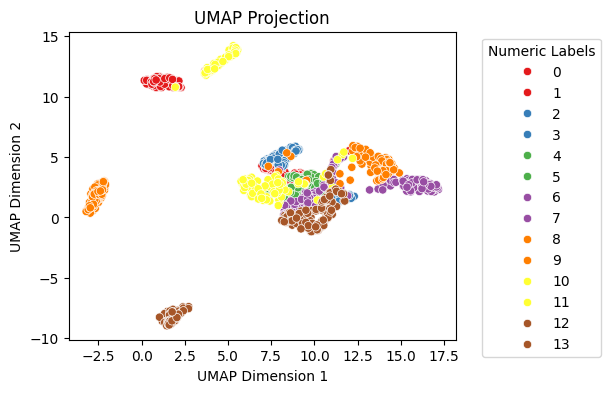

The chosen cluster to analyze is: 0
Common Cluster 0 contains the following politicians:
  ad-be_p1: 2 times
  ad-cdu_p2: 100 times
  ad-chega_p1: 100 times
  ad-chega_p2: 100 times
  ad-il_p1: 98 times
  ad-il_p2: 3 times
  ad-livre_p1: 3 times
  ad-pan_p2: 96 times
  ad-ps_p1: 100 times
  ad-ps_p2: 17 times


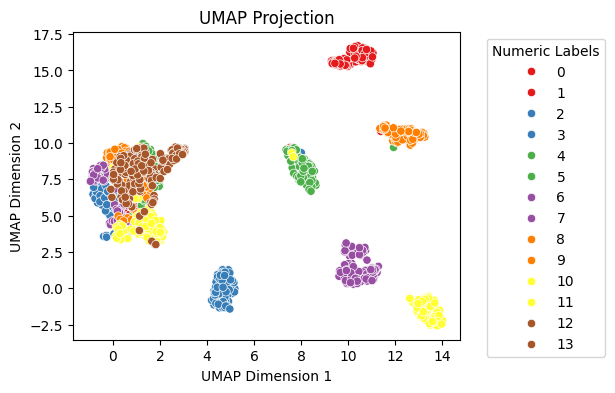

The chosen cluster to analyze is: 0
Common Cluster 0 contains the following politicians:
  ad-be_p2: 96 times
  be-ps_p2: 100 times
  cdu-be_p2: 97 times
  chega-be_p2: 100 times
  il-be_p2: 14 times
  livre-be_p2: 98 times
  pan-be_p1: 91 times
  pan-be_p2: 1 times


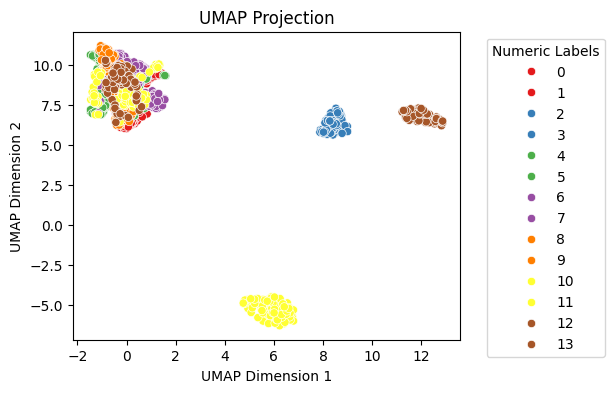

The chosen cluster to analyze is: 0
Common Cluster 0 contains the following politicians:
  ad-cdu_p2: 83 times
  cdu-be_p1: 4 times
  cdu-ps_p1: 76 times
  cdu-ps_p2: 9 times
  chega-cdu_p1: 5 times
  chega-cdu_p2: 65 times
  il-cdu_p1: 1 times
  il-cdu_p2: 81 times
  livre-cdu_p1: 50 times
  livre-cdu_p2: 1 times
  pan-cdu_p2: 10 times


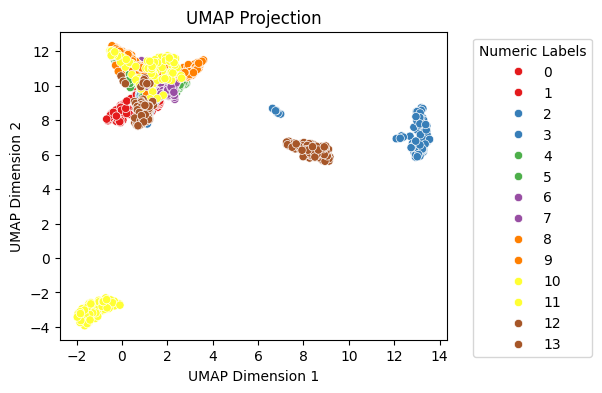

The chosen cluster to analyze is: 6
Common Cluster 6 contains the following politicians:
  ad-chega_p1: 10 times
  ad-chega_p2: 37 times
  chega-be_p1: 36 times
  chega-cdu_p1: 16 times
  chega-cdu_p2: 82 times
  chega-il_p1: 4 times
  chega-il_p2: 3 times
  chega-ps_p1: 6 times
  chega-ps_p2: 8 times
  livre-chega_p1: 81 times
  pan-chega_p1: 12 times


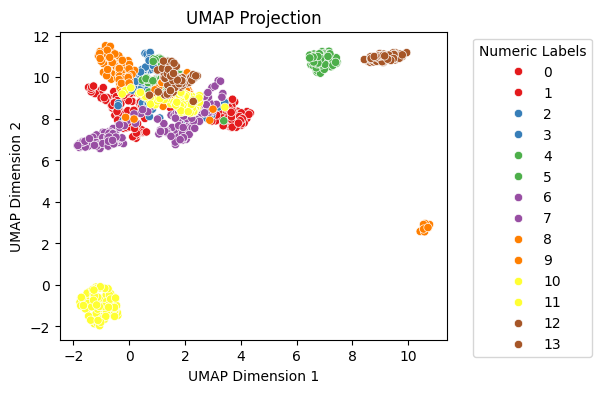

The chosen cluster to analyze is: 1
Common Cluster 1 contains the following politicians:
  chega-il_p1: 2 times
  chega-il_p2: 91 times
  il-be_p1: 98 times
  il-cdu_p1: 13 times
  il-cdu_p2: 1 times
  il-ps_p1: 1 times
  il-ps_p2: 90 times
  livre-il_p1: 99 times
  pan-il_p1: 98 times


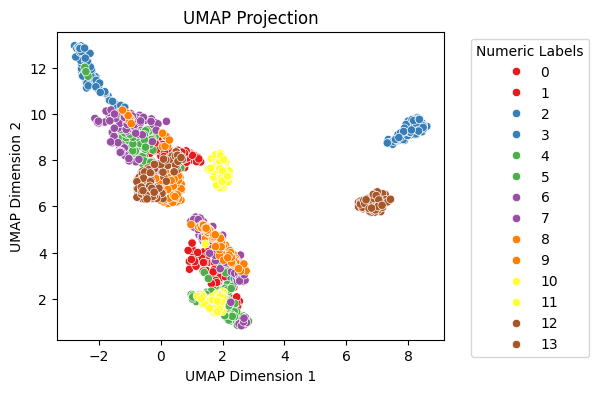

The chosen cluster to analyze is: 1
Common Cluster 1 contains the following politicians:
  ad-livre_p1: 100 times
  livre-be_p1: 3 times
  livre-cdu_p1: 99 times
  livre-chega_p1: 100 times
  livre-chega_p2: 6 times
  livre-il_p1: 100 times
  livre-il_p2: 1 times
  livre-ps_p1: 1 times


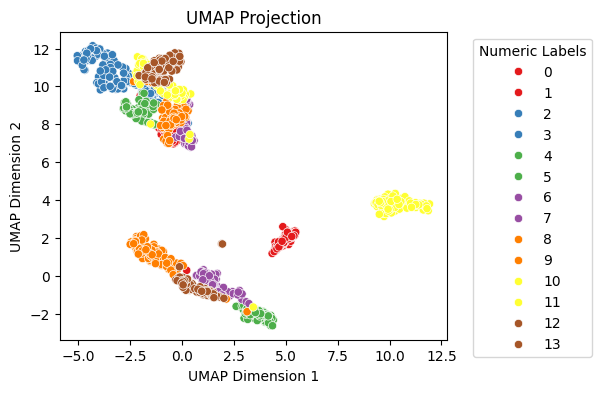

The chosen cluster to analyze is: 0
Common Cluster 0 contains the following politicians:
  ad-pan_p1: 100 times
  pan-be_p1: 99 times
  pan-be_p2: 100 times
  pan-il_p2: 98 times
  pan-ps_p1: 100 times


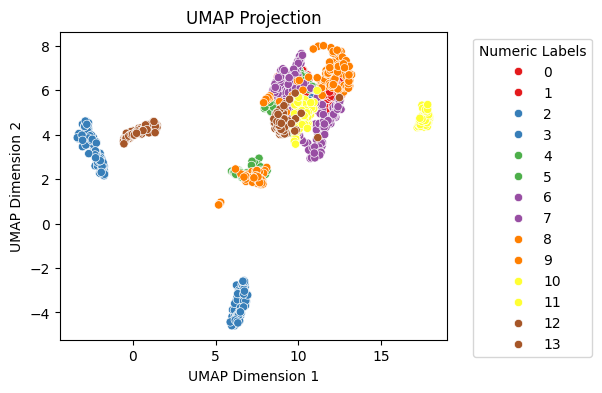

The chosen cluster to analyze is: 0
Common Cluster 0 contains the following politicians:
  be-ps_p1: 3 times
  cdu-ps_p1: 97 times
  cdu-ps_p2: 9 times
  chega-ps_p1: 97 times
  chega-ps_p2: 97 times
  il-ps_p1: 6 times
  il-ps_p2: 93 times
  livre-ps_p1: 98 times
  pan-ps_p2: 100 times


,debate,winner,winner_name,score
0,ad-be,Politic 1,Ad,1.000000
1,ad-cdu,Politic 2,Ad,1.000000
2,ad-chega,Politic 2,Ad,0.500000
3,ad-il,Politic 1,Ad,0.970297
4,ad-livre,Politic 1,Ad,1.000000
5,ad-pan,Politic 2,Ad,1.000000
6,ad-ps,Politic 1,Ad,0.854701


,debate,winner,winner_name,score
0,ad-be,Politic 2,Be,1.00000
1,be-ps,Politic 2,Be,1.00000
2,cdu-be,Politic 2,Be,1.00000
3,chega-be,Politic 2,Be,1.00000
4,il-be,Politic 2,Be,1.00000
5,livre-be,Politic 2,Be,1.00000
6,pan-be,Politic 1,Be,0.98913


,debate,winner,winner_name,score
0,ad-cdu,Politic 2,Cdu,1.000000
1,cdu-be,Politic 1,Cdu,1.000000
2,cdu-ps,Politic 1,Cdu,0.894118
3,chega-cdu,Politic 2,Cdu,0.928571
4,il-cdu,Politic 2,Cdu,0.987805
5,livre-cdu,Politic 1,Cdu,0.980392
6,pan-cdu,Politic 2,Cdu,1.000000


,debate,winner,winner_name,score
0,ad-chega,Politic 2,Chega,0.787234
1,chega-be,Politic 1,Chega,1.000000
2,chega-cdu,Politic 2,Chega,0.836735
3,chega-il,Politic 1,Chega,0.571429
4,chega-ps,Politic 2,Chega,0.571429
5,livre-chega,Politic 1,Chega,1.000000
6,pan-chega,Politic 1,Chega,1.000000


,debate,winner,winner_name,score
0,chega-il,Politic 2,Il,0.978495
1,il-be,Politic 1,Il,1.000000
2,il-cdu,Politic 1,Il,0.928571
3,il-ps,Politic 2,Il,0.989011
4,livre-il,Politic 1,Il,1.000000
5,pan-il,Politic 1,Il,1.000000


,debate,winner,winner_name,score
0,ad-livre,Politic 1,Livre,1.000000
1,livre-be,Politic 1,Livre,1.000000
2,livre-cdu,Politic 1,Livre,1.000000
3,livre-chega,Politic 1,Livre,0.943396
4,livre-il,Politic 1,Livre,0.990099
5,livre-ps,Politic 1,Livre,1.000000


,debate,winner,winner_name,score
0,ad-pan,Politic 1,Pan,1.000000
1,pan-be,Politic 2,Pan,0.502513
2,pan-il,Politic 2,Pan,1.000000
3,pan-ps,Politic 1,Pan,1.000000


,debate,winner,winner_name,score
0,be-ps,Politic 1,Ps,1.000000
1,cdu-ps,Politic 1,Ps,0.915094
2,chega-ps,Politic 2,Ps,0.500000
3,il-ps,Politic 2,Ps,0.939394
4,livre-ps,Politic 1,Ps,1.000000
5,pan-ps,Politic 2,Ps,1.000000


In [9]:
parties = ['ad', 'be', 'cdu', 'chega', 'il', 'livre', 'pan', 'ps']
all_party_winners = {}

for party in parties:
    winner_df = party_winners(video_titles, current_dir, party)
    all_party_winners[party] = winner_df
    
for party in parties:
    display(all_party_winners[party])

In [10]:
# Merge all the dataframes
all_winners_df = pd.concat(all_party_winners.values())

# Display the number of unique debates
num_debates = len(all_winners_df['debate'].unique())
print(f"Number of unique debates: {num_debates}")

# Initialize the conclusions dataframe for 28 debates
conclusions_df = pd.DataFrame(columns=['debate', 'Politic 1', 'Politic 2'])
initial_data = [{'debate': debate, 'Politic 1': '', 'Politic 2': ''} for debate in video_titles]
conclusions_df = pd.concat([conclusions_df, pd.DataFrame(initial_data)], ignore_index=True)

# Process each unique debate
for debate in all_winners_df['debate'].unique():
    debate_guesses = all_winners_df[all_winners_df['debate'] == debate]
    unique_winners = debate_guesses['winner'].unique()
    #display(debate_guesses)
    if len(unique_winners) > 1:
        p1_winner = debate_guesses[debate_guesses['winner'] == 'Politic 1'].iloc[0]['winner_name']
        p2_winner = debate_guesses[debate_guesses['winner'] == 'Politic 2'].iloc[0]['winner_name']
        
        conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 1'] = p1_winner
        conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 2'] = p2_winner
    
    elif len(unique_winners) == 1 and len(debate_guesses) == 2:
        # Determine the winner based on the best score, skip if scores are tied
        if debate_guesses.iloc[0]['score'] == debate_guesses.iloc[1]['score']:
            continue
        
        winner_name = debate_guesses.iloc[1]['winner_name'] if debate_guesses.iloc[0]['score'] < debate_guesses.iloc[1]['score'] else debate_guesses.iloc[0]['winner_name']
            
        if unique_winners[0] == 'Politic 1':
            conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 1'] = winner_name
        else:
            conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 2'] = winner_name

    elif len(unique_winners) == 1 and len(debate_guesses) == 1:
        winner_name = debate_guesses.iloc[0]['winner_name']
        if unique_winners[0] == 'Politic 1':
            conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 1'] = winner_name
        else:
            conclusions_df.loc[conclusions_df['debate'] == debate, 'Politic 2'] = winner_name

# Display the conclusions dataframe
#display(conclusions_df)

party_map = {'Ad': 'Luís Montenegro - AD', 'Be': 'Mariana Mortágua - BE', 'Cdu': 'Paulo Raimundo - CDU', 'Chega': 'André Ventura - CHEGA', 'Il': 'Rui Rocha - IL', 'Livre': 'Rui Tavares - LIVRE', 'Pan': 'Inês Sousa Real - PAN', 'Ps': 'Pedro Nuno Santos - PS'}

# Complete the missing values in the conclusions dataframe
for index, debate in conclusions_df.iterrows():
    
    if debate['Politic 1'] == '' and debate['Politic 2'] != '':
        p2 = debate['Politic 2'].lower()
        debate_name = debate['debate']
        party1 = debate_name.split('-')[0]
        party2 = debate_name.split('-')[1]
        if p2 == party1:
            conclusions_df.loc[index, 'Politic 1'] = party2.capitalize()
        else:
            conclusions_df.loc[index, 'Politic 1'] = party1.capitalize()
    elif debate['Politic 1'] != '' and debate['Politic 2'] == '':
        p1 = debate['Politic 1'].lower()
        debate_name = debate['debate']
        party1 = debate_name.split('-')[0]
        party2 = debate_name.split('-')[1]
        if p1 == party1: #firt letter capital
            conclusions_df.loc[index, 'Politic 2'] = party2.capitalize()
        else:
            conclusions_df.loc[index, 'Politic 2'] = party1.capitalize()
            
    #Replace party name with the full name
    
    p1 = conclusions_df.loc[index, 'Politic 1']
    p2 = conclusions_df.loc[index, 'Politic 2']
    if p1 != '':
        new_p1 = party_map[p1]
        conclusions_df.loc[index, 'Politic 1'] = new_p1

    if p2 != '':
        new_p2 = party_map[p2]
        conclusions_df.loc[index, 'Politic 2'] = new_p2
    

# Display the conclusions dataframe
display(conclusions_df)

Number of unique debates: 27


,debate,Politic 1,Politic 2
0,ad-be,Luís Montenegro - AD,Mariana Mortágua - BE
1,ad-cdu,,
2,ad-chega,Luís Montenegro - AD,André Ventura - CHEGA
3,ad-il,Luís Montenegro - AD,Rui Rocha - IL
4,ad-livre,,
5,ad-pan,Inês Sousa Real - PAN,Luís Montenegro - AD
6,ad-ps,Luís Montenegro - AD,Pedro Nuno Santos - PS
7,be-ps,Pedro Nuno Santos - PS,Mariana Mortágua - BE
8,cdu-be,Paulo Raimundo - CDU,Mariana Mortágua - BE
9,cdu-ps,Pedro Nuno Santos - PS,Paulo Raimundo - CDU


In [13]:
for video in video_titles:
    # Read the video pickle file
    data = pd.read_pickle(os.path.join(current_dir, 'labeled', video + '_labeled.pkl'))
    labeled_df = data.copy()
    
    if we_have_new_label(video, conclusions_df):
        labeled_df = update_labels(labeled_df, conclusions_df, video)
        #visualize_labeled_df(labeled_df, images_per_cluster=5, images_per_row=5)
    else:
        print(video, "no")
        
    # Save the labeled dataframe to a pickle file
    labeled_df.to_pickle(os.path.join(current_dir, 'labeled', video + '_labeled.pkl'))

ad-cdu no
ad-livre no
livre-ps no
pan-livre no


In [14]:
for video in video_titles:
    data = pd.read_pickle(os.path.join(current_dir, 'labeled', video + '_labeled.pkl'))
    data.sort_values('filename', inplace=True)
    data.reset_index(drop=True, inplace=True)

    labeled_df = data.copy()

    print(video)
    for cluster in labeled_df['cluster_id'].sort_values().unique():
        # Print the cluster details
        print(f"Cluster {cluster} ({labeled_df[labeled_df['cluster_id'] == cluster]['cluster_label'].iloc[0]}) -> size: {len(labeled_df[labeled_df['cluster_id'] == cluster])} frames")
    print()

ad-be
Cluster 0 (Others) -> size: 122 frames
Cluster 1 (Split-view) -> size: 748 frames
Cluster 2 (Luís Montenegro - AD) -> size: 548 frames
Cluster 3 (Mariana Mortágua - BE) -> size: 487 frames
Cluster 4 (Moderator) -> size: 155 frames

ad-cdu
Cluster -1 (Removed Frame) -> size: 46 frames
Cluster 0 (Others) -> size: 223 frames
Cluster 1 (Split-view) -> size: 689 frames
Cluster 2 (Politic 1) -> size: 533 frames
Cluster 3 (Politic 2) -> size: 422 frames
Cluster 4 (Moderator) -> size: 104 frames

ad-chega
Cluster -1 (Removed Frame) -> size: 7 frames
Cluster 0 (Split-view) -> size: 1031 frames
Cluster 1 (Others) -> size: 166 frames
Cluster 2 (Luís Montenegro - AD) -> size: 686 frames
Cluster 3 (André Ventura - CHEGA) -> size: 295 frames
Cluster 4 (Moderator) -> size: 182 frames

ad-il
Cluster -1 (Removed Frame) -> size: 9 frames
Cluster 0 (Split-view) -> size: 637 frames
Cluster 1 (Others) -> size: 239 frames
Cluster 2 (Luís Montenegro - AD) -> size: 444 frames
Cluster 3 (Rui Rocha - IL) 

In [17]:
# Initialize a dictionary to store cumulative durations for each cluster label
cumulative_durations = {}
# Initialize an empty list to accumulate the DataFrames
cumulative_total_time_dfs = []

# Loop over all the videos and apply the clustering and labeling functions
for video in video_titles:
    print(video)
    # Read the video pickle file
    labeled_df = pd.read_pickle(os.path.join(current_dir, 'labeled', video + '_labeled.pkl'))

    smoothed_timeline_df, timeline_df = segment_video_timeline_emotion(labeled_df)
    plot_timeline_w_major_emotion(timeline_df, video)

    plot_total_screen_time(timeline_df, video)
    plot_total_screen_time(smoothed_timeline_df, video)

    display(get_total_time_by_emotion(timeline_df))
    display(get_total_time_by_emotion(smoothed_timeline_df))
    
    # Get total time by emotion for this video
    total_time_by_emotion_df = get_total_time_by_emotion(smoothed_timeline_df)
    
    # Append the DataFrame to the list
    cumulative_total_time_dfs.append(total_time_by_emotion_df)

    # Accumulate durations for each cluster label
    for index, row in smoothed_timeline_df.iterrows():
        cluster_label = row['cluster_label']
        duration = row['duration']
        cumulative_durations[cluster_label] = cumulative_durations.get(cluster_label, 0) + duration

    print(video)
    clusters_order = ['Removed Frame', 'Split-view', 'Politic 1', 'Politic 2', 'Moderator', 'Others']
    for cluster in clusters_order:
        print(f"Cluster: {cluster} -> {len(labeled_df[labeled_df['cluster_label'] == cluster])} frames")
        
# Convert cumulative durations from seconds to minutes
for cluster_label, duration in cumulative_durations.items():
    cumulative_durations[cluster_label] = duration // 60

# Display cumulative durations for each cluster label
cumulative_durations_df = pd.DataFrame(list(cumulative_durations.items()), columns=['cluster_label', 'cumulative_duration(hour)'])
print("\nCumulative Durations:")
print(cumulative_durations_df)

# Concatenate all DataFrames in the list
cumulative_total_time_by_emotion = pd.concat(cumulative_total_time_dfs, ignore_index=True)

# Group by cluster_label and sum the durations to get the total time by emotion
total_time_by_emotion_sum = cumulative_total_time_by_emotion.groupby('cluster_label').sum()
for emotion in total_time_by_emotion_sum.columns:
    print(emotion)
    print(total_time_by_emotion_sum[emotion])
    total_time_by_emotion_sum[f"{emotion}(hour)"] = total_time_by_emotion_sum[emotion].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(extract_number(x) // 3600, extract_number(x) % 3600 // 60, extract_number(x) % 60) if not pd.isnull(x) else '00:00:00')
    total_time_by_emotion_sum = total_time_by_emotion_sum.drop(emotion, axis=1)
    
#total_time_by_emotion_sum['total_duration(min)'] = total_time_by_emotion_sum['duration'].apply(lambda x: '{:02d}:{:02d}'.format(x // 60, x % 60))
#total_time_by_emotion_sum = total_time_by_emotion_sum.drop('duration', axis=1)    

# Display the total times by emotion added up from all the names that appear as a cluster_label
print(total_time_by_emotion_sum)


ad-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Luís Montenegro - AD,00:09:08,00:05:44,00:00:43,00:00:00,00:00:03,00:00:54,00:00:12,00:01:32
1,Mariana Mortágua - BE,00:08:07,00:00:00,00:00:40,00:00:03,00:00:00,00:00:37,00:00:02,00:06:45
2,Moderator,00:02:35,00:00:00,00:00:00,00:01:20,00:00:00,00:00:12,00:00:12,00:00:51
3,Split-view,00:12:28,00:00:32,00:02:58,00:00:00,00:00:00,00:00:15,00:00:00,00:08:43


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Luís Montenegro - AD,00:09:59,00:06:41,00:00:01,00:00:00,00:02:29,00:00:00,00:00:47
1,Mariana Mortágua - BE,00:08:33,00:00:00,00:00:08,00:00:00,00:00:00,00:00:00,00:08:25
2,Moderator,00:02:22,00:00:00,00:00:00,00:01:54,00:00:00,00:00:28,00:00:00
3,Others,00:00:11,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:11
4,Split-view,00:13:15,00:00:32,00:03:06,00:00:00,00:00:17,00:00:05,00:09:15


ad-be
Cluster: Removed Frame -> 0 frames
Cluster: Split-view -> 748 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 155 frames
Cluster: Others -> 122 frames
ad-cdu


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:01:44,00:00:05,00:00:46,00:00:14,00:00:04,00:00:09,00:00:04,00:00:22
1,Politic 1,00:08:53,00:05:40,00:00:15,00:00:01,00:00:00,00:02:56,00:00:00,00:00:01
2,Politic 2,00:07:02,00:00:37,00:00:00,00:00:33,00:00:00,00:03:20,00:00:07,00:02:25
3,Split-view,00:11:29,00:00:00,00:00:38,00:00:05,00:00:00,00:05:34,00:01:56,00:03:16


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:00:53,00:00:00,00:00:47,00:00:00,00:00:00,00:00:00
1,Others,00:00:59,00:00:00,00:00:08,00:00:00,00:00:00,00:00:00
2,Politic 1,00:10:14,00:05:22,00:00:00,00:03:21,00:00:00,00:01:31
3,Politic 2,00:08:22,00:00:00,00:00:00,00:04:10,00:00:00,00:04:00
4,Split-view,00:12:18,00:00:00,00:00:29,00:06:53,00:01:35,00:03:16


ad-cdu
Cluster: Removed Frame -> 46 frames
Cluster: Split-view -> 689 frames
Cluster: Politic 1 -> 533 frames
Cluster: Politic 2 -> 422 frames
Cluster: Moderator -> 104 frames
Cluster: Others -> 223 frames
ad-chega


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:04:55,00:00:03,00:00:28,00:00:00,00:00:00,00:00:17,00:00:42,00:03:25
1,Luís Montenegro - AD,00:11:26,00:09:02,00:00:40,00:00:02,00:00:04,00:00:27,00:00:03,00:00:42
2,Moderator,00:03:02,00:00:01,00:01:01,00:00:07,00:00:17,00:00:21,00:00:00,00:01:15
3,Split-view,00:17:11,00:06:22,00:09:18,00:00:00,00:00:00,00:00:00,00:00:34,00:00:57


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:05:55,00:00:00,00:00:01,00:00:00,00:00:00,00:00:19,00:05:35
1,Luís Montenegro - AD,00:13:01,00:11:40,00:00:40,00:00:00,00:00:25,00:00:00,00:00:00
2,Moderator,00:01:17,00:00:00,00:00:51,00:00:02,00:00:00,00:00:00,00:00:00
3,Others,00:00:23,00:00:02,00:00:00,00:00:08,00:00:00,00:00:00,00:00:00
4,Split-view,00:18:44,00:08:00,00:09:46,00:00:00,00:00:00,00:00:00,00:00:58


ad-chega
Cluster: Removed Frame -> 7 frames
Cluster: Split-view -> 1031 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 182 frames
Cluster: Others -> 166 frames
ad-il


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Luís Montenegro - AD,00:07:24,00:05:32,00:00:40,00:00:00,00:00:00,00:00:49,00:00:05,00:00:11
1,Moderator,00:02:16,00:00:08,00:00:04,00:00:13,00:00:00,00:00:58,00:00:00,00:00:43
2,Rui Rocha - IL,00:07:22,00:00:01,00:00:13,00:06:15,00:00:07,00:00:05,00:00:29,00:00:12
3,Split-view,00:10:37,00:02:16,00:06:12,00:00:00,00:00:00,00:01:42,00:00:27,00:00:00


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour)
0,Luís Montenegro - AD,00:07:47,00:07:07,00:00:17,00:00:00,00:00:23,00:00:00
1,Moderator,00:01:22,00:00:00,00:00:04,00:00:11,00:00:24,00:00:00
2,Rui Rocha - IL,00:08:29,00:00:00,00:00:00,00:07:51,00:00:00,00:00:38
3,Split-view,00:13:21,00:02:19,00:08:30,00:00:00,00:02:00,00:00:32


ad-il
Cluster: Removed Frame -> 9 frames
Cluster: Split-view -> 637 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 136 frames
Cluster: Others -> 239 frames
ad-livre


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:43,00:00:00,00:00:03,00:00:40,00:00:07,00:00:12,00:01:41
1,Politic 1,00:10:32,00:08:36,00:00:10,00:00:00,00:01:15,00:00:05,00:00:26
2,Politic 2,00:09:53,00:00:11,00:00:01,00:00:03,00:00:18,00:00:00,00:09:20
3,Split-view,00:04:22,00:00:18,00:00:00,00:00:00,00:01:43,00:00:00,00:02:21


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Neutral(hour),Surprise(hour)
0,Moderator,00:02:05,00:00:00,00:00:02,00:00:00,00:01:31
1,Others,00:00:38,00:00:00,00:00:00,00:00:01,00:00:13
2,Politic 1,00:12:03,00:10:46,00:00:00,00:00:01,00:01:10
3,Politic 2,00:10:27,00:00:00,00:00:00,00:00:00,00:10:27
4,Split-view,00:05:10,00:00:25,00:00:00,00:01:55,00:02:50


ad-livre
Cluster: Removed Frame -> 14 frames
Cluster: Split-view -> 262 frames
Cluster: Politic 1 -> 632 frames
Cluster: Politic 2 -> 593 frames
Cluster: Moderator -> 163 frames
Cluster: Others -> 173 frames
ad-pan


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:06:17,00:00:00,00:00:03,00:01:37,00:00:02,00:00:04,00:00:04,00:04:27
1,Luís Montenegro - AD,00:05:48,00:03:36,00:00:49,00:00:02,00:00:00,00:00:07,00:00:13,00:01:01
2,Moderator,00:01:29,00:00:56,00:00:06,00:00:00,00:00:00,00:00:14,00:00:01,00:00:12
3,Removed Frame,00:00:16,00:00:00,00:00:00,00:00:04,00:00:00,00:00:10,00:00:01,00:00:01
4,Split-view,00:12:39,00:02:56,00:03:33,00:02:29,00:00:00,00:01:16,00:00:00,00:02:25


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:07:26,00:00:30,00:00:00,00:01:30,00:00:02,00:00:00,00:05:16
1,Luís Montenegro - AD,00:05:21,00:04:34,00:00:21,00:00:01,00:00:00,00:00:02,00:00:23
2,Moderator,00:00:42,00:00:28,00:00:00,00:00:00,00:00:00,00:00:00,00:00:09
3,Others,00:01:42,00:00:00,00:00:00,00:00:16,00:00:00,00:00:00,00:00:13
4,Split-view,00:16:16,00:03:15,00:03:10,00:04:38,00:00:00,00:00:51,00:03:40


ad-pan
Cluster: Removed Frame -> 16 frames
Cluster: Split-view -> 759 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 89 frames
Cluster: Others -> 298 frames
ad-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Luís Montenegro - AD,00:26:05,00:17:40,00:00:38,00:00:00,00:00:00,00:01:15,00:00:23,00:06:09
1,Moderator1,00:02:50,00:00:00,00:00:09,00:00:22,00:00:00,00:00:33,00:00:23,00:01:23
2,Moderator2,00:02:53,00:00:00,00:00:06,00:00:00,00:00:00,00:02:23,00:00:00,00:00:24
3,Moderator3,00:03:59,00:00:00,00:00:21,00:00:11,00:00:02,00:00:14,00:00:01,00:03:10
4,Pedro Nuno Santos - PS,00:25:41,00:00:10,00:00:04,00:00:00,00:00:00,00:24:47,00:00:26,00:00:14
5,Removed Frame,00:00:56,00:00:00,00:00:00,00:00:05,00:00:00,00:00:01,00:00:00,00:00:00
6,Split-view,00:12:25,00:00:05,00:01:06,00:00:00,00:00:00,00:10:34,00:00:00,00:00:40


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Luís Montenegro - AD,00:29:28,00:19:59,00:00:00,00:00:00,00:04:52,00:00:00,00:04:32
1,Moderator1,00:02:05,00:00:00,00:00:00,00:00:00,00:00:29,00:00:34,00:00:34
2,Moderator2,00:03:02,00:00:08,00:00:00,00:00:00,00:02:16,00:00:00,00:00:15
3,Moderator3,00:03:18,00:00:00,00:00:00,00:00:00,00:01:24,00:00:00,00:01:54
4,Others,00:01:18,00:00:04,00:00:07,00:00:00,00:00:30,00:00:00,00:00:00
5,Pedro Nuno Santos - PS,00:27:57,00:00:02,00:00:00,00:00:00,00:27:55,00:00:00,00:00:00
6,Removed Frame,00:01:03,00:00:00,00:00:00,00:00:04,00:00:00,00:00:00,00:00:00
7,Split-view,00:14:10,00:00:42,00:00:26,00:00:00,00:11:25,00:00:03,00:01:34


ad-ps
Cluster: Removed Frame -> 56 frames
Cluster: Split-view -> 745 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 0 frames
Cluster: Others -> 452 frames
be-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Fear(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:08:24,00:00:00,00:00:20,00:00:00,00:00:02,00:00:03,00:00:19,00:00:05,00:07:35
1,Moderator,00:02:55,00:00:02,00:01:17,00:00:19,00:00:00,00:00:19,00:00:04,00:00:01,00:00:53
2,Others,00:03:46,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:03,00:00:00,00:00:00
3,Pedro Nuno Santos - PS,00:09:03,00:00:00,00:00:01,00:00:00,00:00:00,00:00:00,00:08:55,00:00:02,00:00:05
4,Split-view,00:13:00,00:00:00,00:05:07,00:00:00,00:00:00,00:00:05,00:00:46,00:00:00,00:07:02


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:09:46,00:00:00,00:00:00,00:00:00,00:00:00,00:09:46
1,Moderator,00:01:47,00:00:29,00:00:15,00:00:20,00:00:02,00:00:26
2,Pedro Nuno Santos - PS,00:10:25,00:00:00,00:00:00,00:00:00,00:10:25,00:00:00
3,Removed Frame,00:00:41,00:00:03,00:00:00,00:00:00,00:00:00,00:00:00
4,Split-view,00:14:23,00:05:38,00:00:00,00:00:00,00:00:58,00:07:47


be-ps
Cluster: Removed Frame -> 33 frames
Cluster: Split-view -> 780 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 175 frames
Cluster: Others -> 226 frames
cdu-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:08:01,00:00:00,00:00:10,00:00:00,00:00:04,00:00:50,00:00:14,00:06:43
1,Moderator,00:01:22,00:00:04,00:00:02,00:00:38,00:00:02,00:00:10,00:00:19,00:00:07
2,Paulo Raimundo - CDU,00:09:03,00:00:03,00:00:00,00:00:04,00:00:00,00:03:34,00:00:25,00:04:57
3,Split-view,00:08:39,00:00:00,00:00:00,00:00:00,00:00:00,00:05:40,00:02:05,00:00:54


,cluster_label,total_duration(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:08:55,00:00:00,00:00:00,00:00:00,00:08:55
1,Moderator,00:00:38,00:00:10,00:00:00,00:00:19,00:00:00
2,Others,00:00:56,00:00:00,00:00:13,00:00:17,00:00:05
3,Paulo Raimundo - CDU,00:10:44,00:00:00,00:04:25,00:01:00,00:05:19
4,Split-view,00:10:42,00:00:00,00:08:17,00:01:19,00:00:55


cdu-be
Cluster: Removed Frame -> 16 frames
Cluster: Split-view -> 519 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 82 frames
Cluster: Others -> 290 frames
cdu-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:26,00:00:14,00:00:05,00:00:09,00:00:02,00:01:09,00:00:02,00:00:45
1,Paulo Raimundo - CDU,00:06:54,00:00:00,00:00:00,00:00:00,00:00:00,00:06:11,00:00:15,00:00:28
2,Pedro Nuno Santos - PS,00:07:43,00:00:00,00:00:00,00:00:12,00:00:00,00:00:31,00:01:53,00:05:07
3,Split-view,00:13:52,00:00:00,00:00:00,00:00:00,00:00:00,00:12:05,00:00:00,00:01:47


,cluster_label,total_duration(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:01:22,00:00:00,00:01:06,00:00:00,00:00:09
1,Paulo Raimundo - CDU,00:07:39,00:00:00,00:07:39,00:00:00,00:00:00
2,Pedro Nuno Santos - PS,00:08:21,00:00:01,00:00:00,00:00:48,00:07:21
3,Split-view,00:15:50,00:00:28,00:12:27,00:00:00,00:02:55


cdu-ps
Cluster: Removed Frame -> 15 frames
Cluster: Split-view -> 832 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 146 frames
Cluster: Others -> 138 frames
chega-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:08:39,00:00:02,00:00:26,00:00:00,00:00:00,00:01:54,00:01:06,00:05:11
1,Mariana Mortágua - BE,00:07:13,00:00:11,00:00:29,00:00:07,00:00:02,00:00:24,00:00:06,00:05:54
2,Moderator,00:02:27,00:00:00,00:00:47,00:00:21,00:00:00,00:00:10,00:00:00,00:01:08
3,Split-view,00:14:55,00:00:00,00:05:11,00:00:00,00:00:00,00:00:27,00:00:00,00:09:17


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:09:55,00:00:00,00:00:00,00:00:44,00:00:51,00:08:20
1,Mariana Mortágua - BE,00:08:03,00:00:00,00:00:00,00:00:00,00:00:00,00:08:03
2,Moderator,00:01:21,00:00:55,00:00:08,00:00:18,00:00:00,00:00:00
3,Split-view,00:16:59,00:06:16,00:00:00,00:00:27,00:00:00,00:10:16


chega-be
Cluster: Removed Frame -> 0 frames
Cluster: Split-view -> 895 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 147 frames
Cluster: Others -> 210 frames
chega-cdu


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Fear(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:08:22,00:00:02,00:00:09,00:00:00,00:00:00,00:00:49,00:00:40,00:06:42
1,Moderator,00:03:19,00:00:10,00:00:00,00:00:02,00:00:15,00:00:19,00:01:05,00:01:28
2,Paulo Raimundo - CDU,00:07:32,00:00:56,00:00:00,00:00:14,00:00:00,00:01:57,00:00:48,00:02:33
3,Split-view,00:10:36,00:00:00,00:00:09,00:00:00,00:00:00,00:00:35,00:03:26,00:06:26


,cluster_label,total_duration(hour),Anger(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:10:06,00:00:00,00:00:00,00:00:00,00:00:00,00:09:56
1,Moderator,00:02:17,00:00:00,00:00:03,00:00:00,00:01:08,00:01:06
2,Others,00:00:29,00:00:09,00:00:00,00:00:02,00:00:00,00:00:00
3,Paulo Raimundo - CDU,00:07:49,00:00:22,00:00:02,00:00:37,00:00:27,00:06:21
4,Split-view,00:11:53,00:00:00,00:00:00,00:00:24,00:03:49,00:07:40


chega-cdu
Cluster: Removed Frame -> 0 frames
Cluster: Split-view -> 636 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 199 frames
Cluster: Others -> 165 frames
chega-il


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Fear(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:07:46,00:00:00,00:00:09,00:00:02,00:00:02,00:00:10,00:00:05,00:02:46,00:04:32
1,Moderator,00:02:56,00:00:01,00:00:00,00:00:26,00:00:00,00:00:00,00:00:07,00:00:42,00:01:40
2,Others,00:03:20,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:01
3,Removed Frame,00:00:14,00:00:00,00:00:01,00:00:00,00:00:01,00:00:00,00:00:04,00:00:01,00:00:01
4,Rui Rocha - IL,00:07:00,00:00:00,00:00:44,00:00:00,00:00:00,00:00:00,00:04:31,00:00:37,00:01:08
5,Split-view,00:09:03,00:00:00,00:00:32,00:00:00,00:00:00,00:00:00,00:03:59,00:04:32,00:00:00


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:09:32,00:00:00,00:00:00,00:00:00,00:02:27,00:07:05
1,Moderator,00:02:03,00:00:00,00:00:08,00:00:00,00:01:55,00:00:00
2,Others,00:00:31,00:00:09,00:00:00,00:00:00,00:00:00,00:00:00
3,Rui Rocha - IL,00:07:30,00:00:00,00:00:01,00:06:09,00:00:26,00:00:54
4,Split-view,00:10:37,00:00:39,00:00:00,00:07:29,00:01:09,00:01:20


chega-il
Cluster: Removed Frame -> 14 frames
Cluster: Split-view -> 543 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 176 frames
Cluster: Others -> 200 frames
chega-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:03:42,00:00:00,00:00:06,00:00:00,00:01:03,00:00:19,00:02:14
1,Moderator,00:01:45,00:00:00,00:00:00,00:00:43,00:00:08,00:00:20,00:00:34
2,Pedro Nuno Santos - PS,00:06:45,00:00:03,00:00:00,00:00:00,00:06:32,00:00:10,00:00:00
3,Split-view,00:22:07,00:00:00,00:00:00,00:00:00,00:21:17,00:00:13,00:00:37


,cluster_label,total_duration(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:03:22,00:00:00,00:00:46,00:00:07,00:02:23
1,Moderator,00:01:20,00:00:10,00:00:01,00:00:17,00:00:01
2,Others,00:01:15,00:00:00,00:00:00,00:00:03,00:00:08
3,Pedro Nuno Santos - PS,00:07:45,00:00:00,00:07:45,00:00:00,00:00:00
4,Split-view,00:24:50,00:00:00,00:24:09,00:00:00,00:00:41


chega-ps
Cluster: Removed Frame -> 16 frames
Cluster: Split-view -> 1327 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 105 frames
Cluster: Others -> 253 frames
il-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:05:22,00:00:00,00:00:21,00:00:00,00:00:44,00:00:02,00:04:15
1,Moderator,00:01:52,00:00:27,00:00:07,00:00:01,00:00:04,00:00:57,00:00:16
2,Rui Rocha - IL,00:07:54,00:00:03,00:00:14,00:00:00,00:04:28,00:00:04,00:03:05
3,Split-view,00:14:46,00:00:10,00:01:29,00:00:00,00:01:48,00:00:00,00:11:19


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:05:26,00:00:09,00:00:00,00:00:00,00:00:00,00:00:00,00:05:17
1,Moderator,00:01:23,00:00:00,00:00:10,00:00:00,00:00:12,00:00:34,00:00:00
2,Others,00:00:14,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:02
3,Rui Rocha - IL,00:08:36,00:00:00,00:00:00,00:00:04,00:05:52,00:00:00,00:02:40
4,Split-view,00:16:01,00:00:05,00:00:28,00:00:00,00:03:34,00:00:00,00:11:54


il-be
Cluster: Removed Frame -> 13 frames
Cluster: Split-view -> 886 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 112 frames
Cluster: Others -> 106 frames
il-cdu


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:51,00:00:10,00:01:06,00:00:13,00:00:04,00:00:28,00:00:00,00:00:50
1,Paulo Raimundo - CDU,00:09:03,00:00:05,00:00:00,00:00:32,00:00:00,00:03:12,00:00:23,00:04:51
2,Rui Rocha - IL,00:10:15,00:00:04,00:00:37,00:00:00,00:00:01,00:09:27,00:00:03,00:00:03
3,Split-view,00:09:45,00:00:00,00:00:36,00:00:03,00:00:00,00:08:42,00:00:00,00:00:24


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Surprise(hour)
0,Moderator,00:00:53,00:00:53,00:00:00,00:00:00,00:00:00,00:00:00
1,Others,00:01:01,00:00:00,00:00:01,00:00:00,00:00:00,00:00:00
2,Paulo Raimundo - CDU,00:10:30,00:00:00,00:00:00,00:00:00,00:03:23,00:07:07
3,Removed Frame,00:00:12,00:00:02,00:00:00,00:00:00,00:00:00,00:00:00
4,Rui Rocha - IL,00:11:59,00:00:00,00:00:00,00:00:01,00:11:58,00:00:00
5,Split-view,00:10:30,00:00:43,00:00:00,00:00:00,00:09:19,00:00:28


il-cdu
Cluster: Removed Frame -> 10 frames
Cluster: Split-view -> 585 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 171 frames
Cluster: Others -> 181 frames
il-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:11,00:00:06,00:00:03,00:00:49,00:00:04,00:01:09
1,Pedro Nuno Santos - PS,00:07:52,00:00:00,00:00:07,00:05:02,00:02:20,00:00:23
2,Rui Rocha - IL,00:05:13,00:00:00,00:00:45,00:03:59,00:00:07,00:00:22
3,Split-view,00:13:15,00:00:00,00:00:14,00:12:16,00:00:45,00:00:00


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:00:38,00:00:01,00:00:00,00:00:00,00:00:03,00:00:00,00:00:34
1,Pedro Nuno Santos - PS,00:08:31,00:00:00,00:00:00,00:00:02,00:08:22,00:00:00,00:00:07
2,Rui Rocha - IL,00:05:18,00:00:00,00:00:03,00:00:00,00:05:06,00:00:09,00:00:00
3,Split-view,00:15:55,00:00:00,00:00:20,00:00:00,00:15:09,00:00:26,00:00:00


il-ps
Cluster: Removed Frame -> 0 frames
Cluster: Split-view -> 795 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 131 frames
Cluster: Others -> 113 frames
livre-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:09:46,00:00:00,00:00:35,00:00:03,00:00:10,00:00:35,00:00:21,00:08:02
1,Moderator,00:01:17,00:00:02,00:00:06,00:00:14,00:00:00,00:00:14,00:00:10,00:00:31
2,Removed Frame,00:00:32,00:00:00,00:00:00,00:00:02,00:00:02,00:00:11,00:00:14,00:00:01
3,Rui Tavares - LIVRE,00:10:57,00:00:04,00:00:13,00:00:00,00:00:02,00:00:52,00:00:00,00:09:46
4,Split-view,00:05:17,00:00:00,00:00:00,00:00:00,00:00:00,00:02:51,00:00:00,00:02:26


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Mariana Mortágua - BE,00:10:51,00:00:19,00:00:00,00:00:01,00:00:00,00:00:00,00:10:31
1,Moderator,00:00:23,00:00:00,00:00:07,00:00:00,00:00:00,00:00:01,00:00:00
2,Others,00:00:51,00:00:03,00:00:00,00:00:00,00:00:00,00:00:10,00:00:19
3,Rui Tavares - LIVRE,00:12:10,00:00:02,00:00:00,00:00:00,00:00:09,00:00:00,00:11:47
4,Split-view,00:06:30,00:00:00,00:00:00,00:00:00,00:03:38,00:00:00,00:02:52


livre-be
Cluster: Removed Frame -> 32 frames
Cluster: Split-view -> 317 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 77 frames
Cluster: Others -> 178 frames
livre-cdu


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:22,00:00:02,00:00:07,00:00:00,00:00:05,00:00:00,00:02:08
1,Paulo Raimundo - CDU,00:08:34,00:00:08,00:00:00,00:00:00,00:00:10,00:00:00,00:08:16
2,Rui Tavares - LIVRE,00:13:59,00:00:13,00:00:00,00:00:10,00:01:44,00:01:04,00:10:48
3,Split-view,00:04:44,00:00:00,00:00:00,00:00:00,00:02:39,00:00:00,00:02:05


,cluster_label,total_duration(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:24,00:00:00,00:00:00,00:02:24
1,Paulo Raimundo - CDU,00:08:44,00:00:00,00:00:11,00:08:33
2,Rui Tavares - LIVRE,00:14:46,00:03:04,00:00:00,00:11:42
3,Split-view,00:05:02,00:03:01,00:00:00,00:02:01


livre-cdu
Cluster: Removed Frame -> 15 frames
Cluster: Split-view -> 284 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 142 frames
Cluster: Others -> 82 frames
livre-chega


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:08:58,00:00:02,00:00:19,00:00:00,00:00:09,00:00:28,00:01:35,00:06:25
1,Moderator,00:01:27,00:00:00,00:00:02,00:00:12,00:00:00,00:00:16,00:00:19,00:00:38
2,Rui Tavares - LIVRE,00:07:40,00:00:04,00:00:19,00:00:08,00:00:07,00:01:09,00:00:00,00:05:53
3,Split-view,00:13:20,00:00:00,00:00:00,00:00:00,00:00:00,00:04:39,00:00:00,00:08:41


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:10:23,00:00:06,00:00:00,00:00:03,00:00:02,00:10:12
1,Moderator,00:00:36,00:00:02,00:00:20,00:00:04,00:00:10,00:00:00
2,Others,00:00:56,00:00:01,00:00:00,00:00:00,00:00:22,00:00:14
3,Rui Tavares - LIVRE,00:08:02,00:00:00,00:00:02,00:00:00,00:00:03,00:07:36
4,Split-view,00:15:30,00:00:00,00:00:00,00:05:30,00:00:00,00:10:00


livre-chega
Cluster: Removed Frame -> 14 frames
Cluster: Split-view -> 800 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 87 frames
Cluster: Others -> 242 frames
livre-il


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:01:38,00:00:06,00:00:08,00:00:02,00:00:09,00:00:51,00:00:22
1,Removed Frame,00:00:14,00:00:00,00:00:02,00:00:01,00:00:10,00:00:01,00:00:00
2,Rui Rocha - IL,00:03:45,00:00:00,00:00:17,00:00:03,00:02:42,00:00:00,00:00:43
3,Rui Tavares - LIVRE,00:02:34,00:00:04,00:00:03,00:00:00,00:00:20,00:00:00,00:02:07
4,Split-view,00:24:57,00:00:00,00:00:00,00:00:00,00:09:16,00:00:00,00:15:41


,cluster_label,total_duration(hour),Contempt(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:00:20,00:00:00,00:00:00,00:00:20,00:00:00
1,Removed Frame,00:00:01,00:00:00,00:00:01,00:00:00,00:00:00
2,Rui Rocha - IL,00:04:04,00:00:02,00:03:38,00:00:00,00:00:24
3,Rui Tavares - LIVRE,00:01:36,00:00:03,00:00:00,00:00:00,00:01:33
4,Split-view,00:29:40,00:00:00,00:00:00,00:00:00,00:29:40


livre-il
Cluster: Removed Frame -> 14 frames
Cluster: Split-view -> 1497 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 98 frames
Cluster: Others -> 255 frames
livre-ps


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:02:32,00:00:00,00:00:20,00:00:12,00:00:18,00:00:07,00:00:00,00:01:35
1,Politic 1,00:10:00,00:00:00,00:00:00,00:00:00,00:00:00,00:08:37,00:01:19,00:00:04
2,Politic 2,00:09:30,00:00:18,00:00:04,00:00:00,00:00:00,00:00:14,00:00:04,00:08:09
3,Split-view,00:08:34,00:00:04,00:00:06,00:00:00,00:00:00,00:07:33,00:00:46,00:00:05


,cluster_label,total_duration(hour),Contempt(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:01:08,00:00:33,00:00:35,00:00:00,00:00:00,00:00:00
1,Others,00:00:08,00:00:00,00:00:00,00:00:00,00:00:00,00:00:06
2,Politic 1,00:11:54,00:00:00,00:00:00,00:11:54,00:00:00,00:00:00
3,Politic 2,00:10:04,00:00:00,00:00:00,00:00:00,00:00:00,00:10:04
4,Split-view,00:09:56,00:00:00,00:00:00,00:08:42,00:01:14,00:00:00


livre-ps
Cluster: Removed Frame -> 49 frames
Cluster: Split-view -> 514 frames
Cluster: Politic 1 -> 600 frames
Cluster: Politic 2 -> 570 frames
Cluster: Moderator -> 152 frames
Cluster: Others -> 159 frames
pan-be


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:06:42,00:00:00,00:00:04,00:00:43,00:00:00,00:00:04,00:00:00,00:05:51
1,Mariana Mortágua - BE,00:08:01,00:00:00,00:00:02,00:00:00,00:00:00,00:00:20,00:00:01,00:07:28
2,Moderator,00:01:20,00:00:29,00:00:00,00:00:02,00:00:04,00:00:45,00:00:00,00:00:00
3,Removed Frame,00:00:04,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:04,00:00:00
4,Split-view,00:14:55,00:00:00,00:00:00,00:00:00,00:00:00,00:06:23,00:00:00,00:08:32


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:07:11,00:00:00,00:00:00,00:00:13,00:00:00,00:06:58
1,Mariana Mortágua - BE,00:08:50,00:00:00,00:00:00,00:00:00,00:00:01,00:08:35
2,Moderator,00:00:40,00:00:08,00:00:01,00:00:00,00:00:31,00:00:00
3,Split-view,00:15:47,00:00:00,00:00:00,00:00:00,00:06:48,00:08:59


pan-be
Cluster: Removed Frame -> 4 frames
Cluster: Split-view -> 895 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 80 frames
Cluster: Others -> 116 frames
pan-cdu


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:10:56,00:00:00,00:00:00,00:00:06,00:00:22,00:00:34,00:00:03,00:09:51
1,Moderator,00:05:00,00:00:03,00:01:06,00:00:10,00:00:34,00:01:01,00:00:04,00:02:02
2,Paulo Raimundo - CDU,00:10:24,00:00:34,00:00:02,00:00:29,00:00:00,00:04:33,00:01:06,00:03:23
3,Split-view,00:02:24,00:00:00,00:00:00,00:00:11,00:00:00,00:01:08,00:00:08,00:00:57


,cluster_label,total_duration(hour),Contempt(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:13:20,00:00:00,00:00:00,00:00:00,00:13:20
1,Moderator,00:02:48,00:01:09,00:00:18,00:00:09,00:01:01
2,Paulo Raimundo - CDU,00:12:13,00:00:00,00:08:50,00:00:00,00:03:23
3,Removed Frame,00:00:11,00:00:00,00:00:00,00:00:00,00:00:01
4,Split-view,00:02:31,00:00:00,00:01:28,00:00:00,00:01:03


pan-cdu
Cluster: Removed Frame -> 10 frames
Cluster: Split-view -> 144 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 300 frames
Cluster: Others -> 136 frames
pan-chega


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Fear(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:08:19,00:00:00,00:00:02,00:00:00,00:00:00,00:00:02,00:01:43,00:00:40,00:05:52
1,Inês Sousa Real - PAN,00:07:55,00:00:00,00:00:00,00:00:18,00:00:03,00:00:01,00:00:07,00:00:00,00:07:26
2,Moderator,00:03:57,00:00:27,00:00:18,00:00:08,00:00:00,00:00:13,00:00:12,00:00:00,00:02:39
3,Split-view,00:07:17,00:00:00,00:00:48,00:01:05,00:00:00,00:00:05,00:00:30,00:00:16,00:04:33


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,André Ventura - CHEGA,00:09:28,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:09:28
1,Inês Sousa Real - PAN,00:09:21,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:09:21
2,Moderator,00:03:04,00:00:28,00:00:00,00:00:20,00:00:00,00:00:00,00:02:09
3,Others,00:00:36,00:00:00,00:00:00,00:00:00,00:00:00,00:00:12,00:00:00
4,Split-view,00:07:59,00:00:00,00:00:49,00:00:45,00:00:36,00:00:20,00:05:29


pan-chega
Cluster: Removed Frame -> 11 frames
Cluster: Split-view -> 437 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 237 frames
Cluster: Others -> 180 frames
pan-il


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Fear(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:07:17,00:00:00,00:00:00,00:01:05,00:00:00,00:00:04,00:00:06,00:00:13,00:05:49
1,Moderator,00:01:25,00:00:04,00:00:10,00:00:05,00:00:03,00:00:01,00:00:23,00:00:13,00:00:26
2,Removed Frame,00:00:18,00:00:00,00:00:00,00:00:00,00:00:02,00:00:00,00:00:01,00:00:03,00:00:02
3,Rui Rocha - IL,00:09:04,00:00:04,00:01:11,00:00:00,00:00:00,00:00:03,00:07:34,00:00:05,00:00:07
4,Split-view,00:08:20,00:00:00,00:03:45,00:03:22,00:00:00,00:00:00,00:01:13,00:00:00,00:00:00


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:08:28,00:00:00,00:00:07,00:00:00,00:00:00,00:08:21
1,Moderator,00:00:16,00:00:10,00:00:00,00:00:01,00:00:00,00:00:00
2,Others,00:00:51,00:00:14,00:00:00,00:00:00,00:00:00,00:00:00
3,Removed Frame,00:00:02,00:00:00,00:00:00,00:00:00,00:00:02,00:00:00
4,Rui Rocha - IL,00:10:35,00:00:04,00:00:00,00:00:00,00:10:31,00:00:00
5,Split-view,00:10:08,00:05:17,00:01:25,00:00:00,00:01:33,00:01:53


pan-il
Cluster: Removed Frame -> 18 frames
Cluster: Split-view -> 500 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 85 frames
Cluster: Others -> 236 frames
pan-livre


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Moderator,00:01:40,00:00:00,00:00:27,00:00:09,00:00:01,00:00:34,00:00:03,00:00:26
1,Politic 1,00:10:46,00:00:46,00:00:00,00:00:00,00:00:00,00:00:25,00:00:00,00:09:35
2,Politic 2,00:09:49,00:00:00,00:00:02,00:00:29,00:00:06,00:00:15,00:00:02,00:08:55
3,Split-view,00:06:54,00:02:10,00:00:00,00:00:00,00:00:09,00:01:34,00:00:00,00:03:01


,cluster_label,total_duration(hour),Anger(hour),Contempt(hour),Disgust(hour),Happiness(hour),Neutral(hour),Surprise(hour)
0,Moderator,00:00:35,00:00:00,00:00:35,00:00:00,00:00:00,00:00:00,00:00:00
1,Others,00:00:29,00:00:00,00:00:00,00:00:00,00:00:02,00:00:00,00:00:00
2,Politic 1,00:11:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:11:58
3,Politic 2,00:11:38,00:00:00,00:00:00,00:00:33,00:00:00,00:00:00,00:11:05
4,Split-view,00:07:22,00:02:20,00:00:00,00:00:00,00:00:06,00:01:46,00:03:10


pan-livre
Cluster: Removed Frame -> 0 frames
Cluster: Split-view -> 414 frames
Cluster: Politic 1 -> 646 frames
Cluster: Politic 2 -> 589 frames
Cluster: Moderator -> 100 frames
Cluster: Others -> 173 frames
pan-ps


,cluster_label,total_duration(hour),Contempt(hour),Disgust(hour),Fear(hour),Happiness(hour),Neutral(hour),Sadness(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:09:02,00:00:04,00:00:20,00:00:00,00:00:10,00:00:16,00:00:00,00:08:12
1,Moderator,00:04:24,00:00:04,00:01:00,00:00:00,00:00:00,00:01:03,00:00:07,00:02:10
2,Pedro Nuno Santos - PS,00:09:01,00:00:00,00:00:01,00:00:02,00:00:02,00:08:48,00:00:02,00:00:06
3,Split-view,00:05:32,00:00:00,00:00:00,00:00:00,00:00:00,00:05:32,00:00:00,00:00:00


,cluster_label,total_duration(hour),Disgust(hour),Neutral(hour),Surprise(hour)
0,Inês Sousa Real - PAN,00:09:57,00:00:00,00:00:00,00:09:57
1,Moderator,00:03:03,00:00:32,00:00:28,00:01:54
2,Pedro Nuno Santos - PS,00:10:07,00:00:00,00:10:07,00:00:00
3,Split-view,00:06:32,00:00:00,00:06:23,00:00:09


pan-ps
Cluster: Removed Frame -> 4 frames
Cluster: Split-view -> 332 frames
Cluster: Politic 1 -> 0 frames
Cluster: Politic 2 -> 0 frames
Cluster: Moderator -> 264 frames
Cluster: Others -> 113 frames

Cumulative Durations:
             cluster_label  cumulative_duration(hour)
0                Moderator                         37
1    Mariana Mortágua - BE                         60
2     Luís Montenegro - AD                         65
3               Split-view                        357
4                   Others                         17
5            Removed Frame                          6
6                Politic 2                         40
7                Politic 1                         46
8    André Ventura - CHEGA                         58
9           Rui Rocha - IL                         56
10   Inês Sousa Real - PAN                         55
11              Moderator1                          2
12  Pedro Nuno Santos - PS                         73
13              Mode

TypeError: expected string or bytes-like object, got 'int'

In [ ]:
total_time_by_emotion_sum = cumulative_total_time_by_emotion.groupby('cluster_label').sum()
for emotion in total_time_by_emotion_sum.columns:
    print(emotion)
    print(total_time_by_emotion_sum[emotion])
    total_time_by_emotion_sum[f"{emotion}(hour)"] = total_time_by_emotion_sum[emotion].apply(lambda x: '{:02d}:{:02d}:{:02d}'.format(extract_number(x) // 3600, extract_number(x) % 3600 // 60, extract_number(x) % 60) if not pd.isnull(x) else '00:00:00')
    total_time_by_emotion_sum = total_time_by_emotion_sum.drop(emotion, axis=1)